In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

In [2]:
if not os.path.exists("../images"):
    os.mkdir("../images")

In [3]:
data = pd.read_csv("../data/model_data.csv").drop("Unnamed: 0", axis=1)
data.head()

,date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,Vax_index
0,2020-04-02,1494.0,12135.0,2932.0,4097,0.33
1,2020-04-03,1788.0,13635.0,2564.0,4102,0.33
2,2020-04-04,1950.0,15469.0,2593.0,3405,0.33
3,2020-04-05,2097.0,16657.0,2592.0,3094,0.33
4,2020-04-06,2264.0,17154.0,2679.0,4407,0.33


In [4]:
data['date'] = pd.to_datetime(data['date'])

'../images/trend_analysis_improved.pdf'

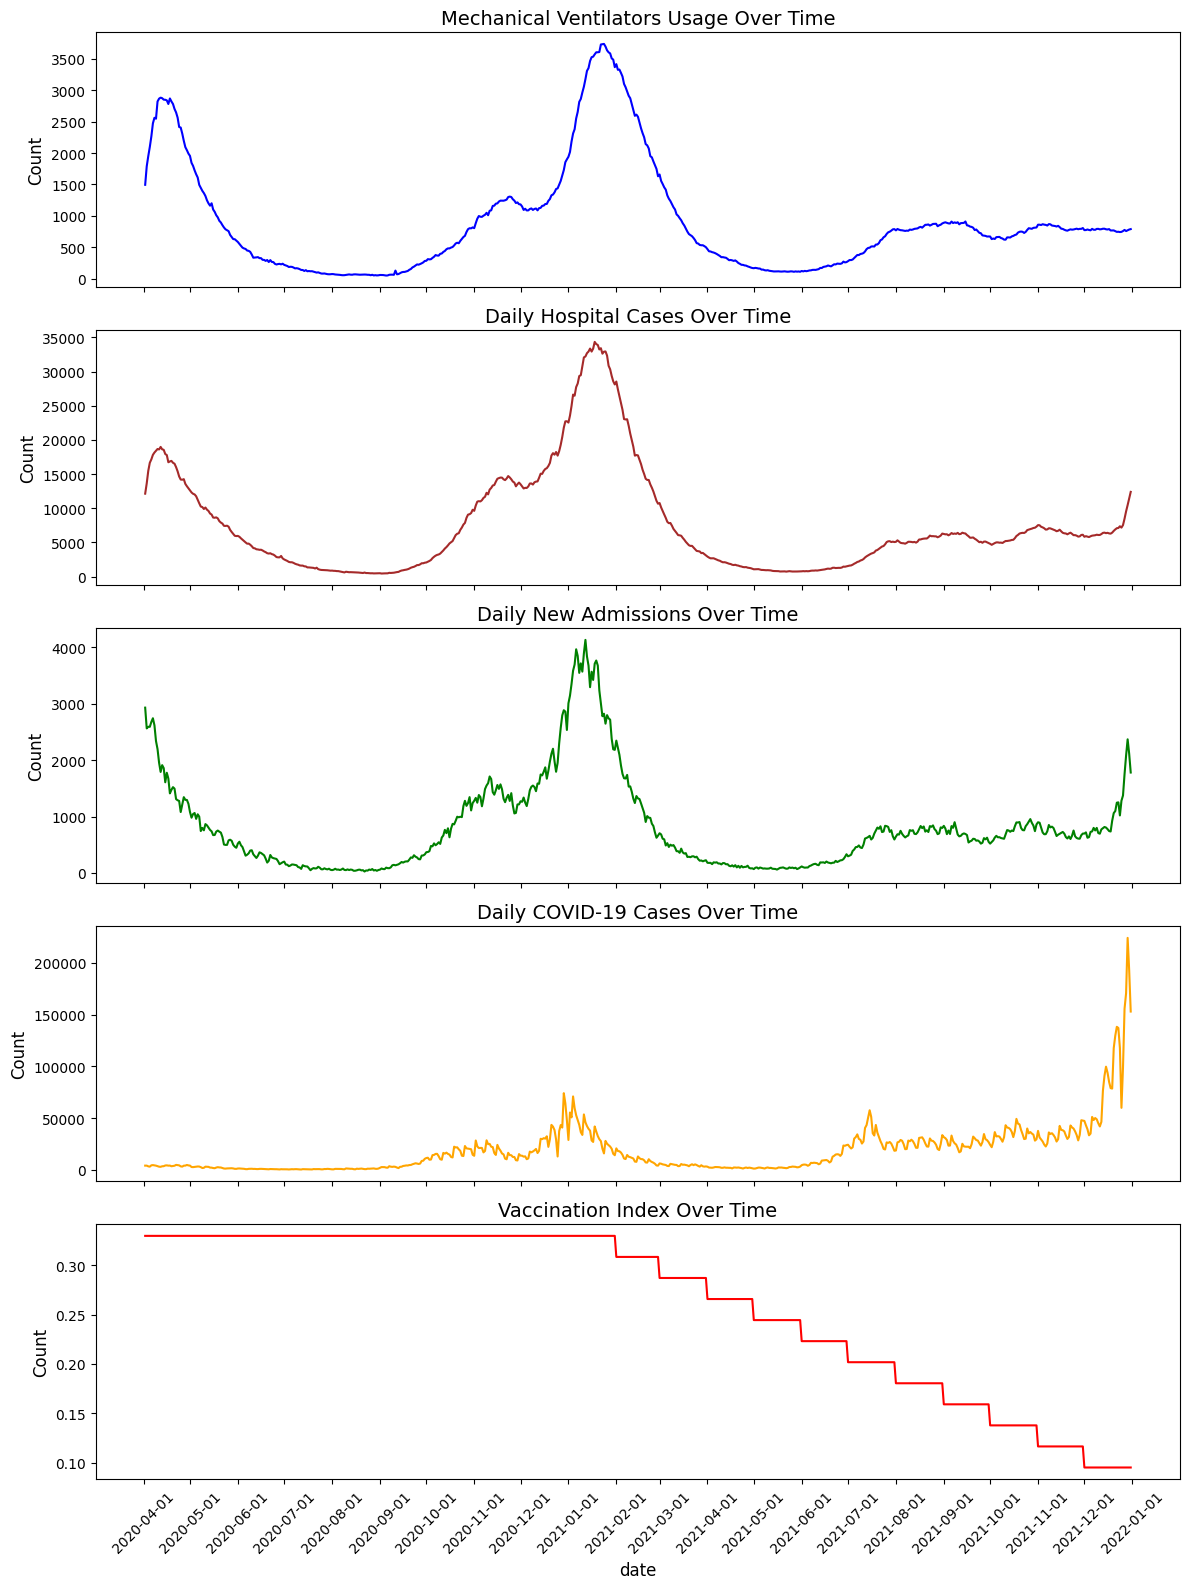

In [5]:
data_image = data[(data['date'] >= '2020-01-01') & (data['date'] <= '2021-12-31')]

# Prepare the figure and subplots with improved readability
fig, axs = plt.subplots(5, 1, figsize=(12, 16), sharex=True)
fig.subplots_adjust(hspace=0.5)

# Define plot details
metrics = ['MV Beds Occupied', 'Hospital Cases', 'New Admissions', 
           'New COVID-19 Cases', 'Vax_index']
colors = ['blue', 'brown', 'green', 'orange', 'red']
titles = ['Mechanical Ventilators Usage Over Time', 'Daily Hospital Cases Over Time', 
          'Daily New Admissions Over Time', 'Daily COVID-19 Cases Over Time', 
     'Vaccination Index Over Time']

# Plot each metric
for ax, metric, color, title in zip(axs, metrics, colors, titles):
    ax.plot(data_image['date'], data_image[metric], color=color)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='both', labelsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())

# Set common x-label
axs[-1].set_xlabel('date', fontsize=12)

# Improve overall layout
plt.tight_layout()

# Save the figure as a PDF
pdf_path_improved = '../images/trend_analysis_improved.pdf'
with PdfPages(pdf_path_improved) as pdf:
    pdf.savefig(fig, bbox_inches='tight')

pdf_path_improved

In [6]:
data.head()

,date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,Vax_index
0,2020-04-02,1494.0,12135.0,2932.0,4097,0.33
1,2020-04-03,1788.0,13635.0,2564.0,4102,0.33
2,2020-04-04,1950.0,15469.0,2593.0,3405,0.33
3,2020-04-05,2097.0,16657.0,2592.0,3094,0.33
4,2020-04-06,2264.0,17154.0,2679.0,4407,0.33


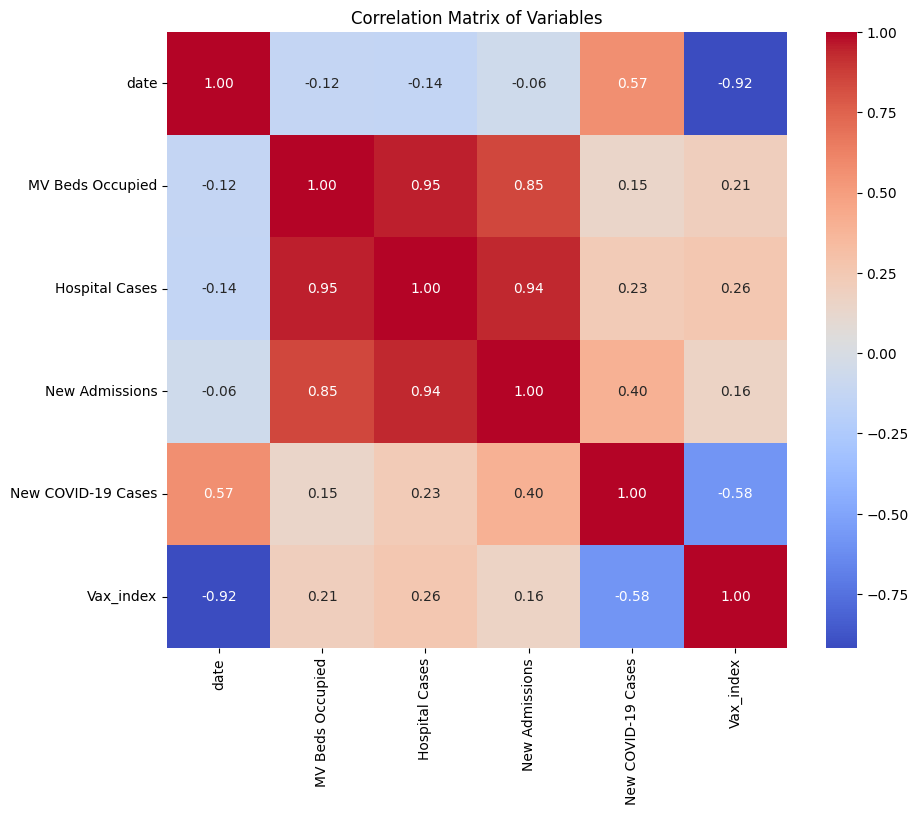

In [7]:
# Correlation analysis
correlation_matrix = data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()

In [8]:
# Time-lagged correlation analysis
lag_days = [1,7,14]  # Lag in days (1 day, 1 week, 2 weeks)
lagged_correlations = pd.DataFrame()

# Looping through different lag days
for lag in lag_days:
    # Create a temporary DataFrame to store lagged data
    temp_df = data[['MV Beds Occupied', 'Hospital Cases', 'New Admissions', 'New COVID-19 Cases']].copy()
    
    # Shifting the relevant columns by 'lag' days
    for col in ['Hospital Cases', 'New Admissions', 'New COVID-19 Cases']:
        temp_df[col + f' Lag_{lag}'] = temp_df[col].shift(lag)
    
    # Calculate correlation matrix for the lagged DataFrame
    corr_matrix = temp_df.corr(method="spearman")
    
    # Select correlations of interest (MV Beds Occupied with other variables)
    correlations_of_interest = corr_matrix['MV Beds Occupied'].filter(like='Lag')
    
    # Store results in the main lagged_correlations DataFrame
    lagged_correlations[f'Lag_{lag}_days'] = correlations_of_interest

# Display the lagged correlations
lagged_correlations.T.sort_index()

,Hospital Cases Lag_1,New Admissions Lag_1,New COVID-19 Cases Lag_1
Lag_14_days,NaN,NaN,NaN
Lag_1_days,0.968453,0.912765,0.507527
Lag_7_days,NaN,NaN,NaN


In [9]:
# Function to calculate the optimal lag for each variable
def optimal_lag(target, features, max_lag):
    optimal_lags = {}
    for feature in features:
        min_error = float('inf')
        best_lag = 0

        for lag in range(1, max_lag + 1):
            # Creating the lagged feature
            temp_df = data.copy()
            temp_df[feature + '_lag'] = temp_df[feature].shift(lag)

            # Dropping missing values (introduced by shifting)
            temp_df = temp_df.dropna()

            # Splitting the dataset
            X = temp_df[[feature + '_lag']]
            y = temp_df[target]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

            # Training the model
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Predicting and calculating the error
            predictions = model.predict(X_test)
            error = mean_squared_error(y_test, predictions)

            # Checking if this lag results in a lower error
            if error < min_error:
                min_error = error
                best_lag = lag

        optimal_lags[feature] = best_lag

    return optimal_lags

# Defining the target variable and features
target_variable = 'MV Beds Occupied'
feature_variables = ['Hospital Cases', 'New Admissions', 'New COVID-19 Cases']

# Finding the optimal lag for each feature
max_lag_days = 30  # Maximum lag in days to consider
optimal_lags = optimal_lag(target_variable, feature_variables, max_lag_days)

optimal_lags


{'Hospital Cases': 5, 'New Admissions': 16, 'New COVID-19 Cases': 30}

In [10]:
# Define a function to calculate the optimal lag for each variable using Spearman correlation
def optimal_lag_spearman_ml(data, target, features, max_lag, model):
    optimal_lags = {}
    
    # TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    for feature in features:
        best_spearman_corr = 0
        best_lag = 0

        for lag in range(1, max_lag + 1):
            # Create a lagged feature
            temp_data = data.copy()
            temp_data[feature + '_lag'] = temp_data[feature].shift(lag)
            temp_data.dropna(inplace=True)

            # Cross-validation
            spearman_corrs = []
            for train_index, test_index in tscv.split(temp_data):
                train, test = temp_data.iloc[train_index], temp_data.iloc[test_index]
                
                # Spearman correlation
                corr, _ = spearmanr(train[target], train[feature + '_lag'])
                spearman_corrs.append(corr)

            avg_spearman_corr = np.mean(spearman_corrs)
            if avg_spearman_corr > best_spearman_corr:
                best_spearman_corr = avg_spearman_corr
                best_lag = lag

        optimal_lags[feature] = best_lag

    return optimal_lags

# Define the target variable and features
target_variable = 'MV Beds Occupied'
feature_variables = ['Hospital Cases', 'New Admissions', 'New COVID-19 Cases']
max_lag_days = 30  # Maximum lag in days to consider

# Find the optimal lag for each feature
optimal_lags = optimal_lag_spearman_ml(data, target_variable, feature_variables, max_lag_days, LinearRegression())

optimal_lags



{'Hospital Cases': 1, 'New Admissions': 12, 'New COVID-19 Cases': 30}

In [11]:
from sklearn.preprocessing import StandardScaler

features = data[['MV Beds Occupied', 'Hospital Cases', 'New COVID-19 Cases', 'New Admissions', 'Vax_index']]  # Add other relevant features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


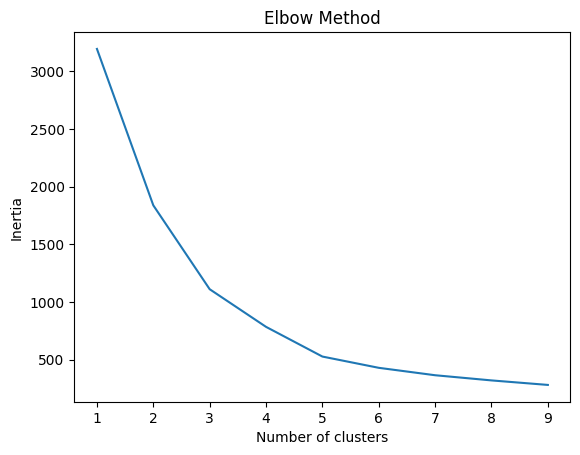

In [12]:
from sklearn.cluster import KMeans

# Elbow method to find the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow graph
plt.plot(range(1, 10), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [13]:
# Apply K-Means with the chosen number of clusters
optimal_k = 4  # Replace with the chosen k
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(features_scaled)

# Assign the clusters to the original data
data['Cluster'] = kmeans.labels_


In [14]:
for i in range(optimal_k):
    cluster = data[data['Cluster'] == i]
    print(f"Cluster {i}:")
    cluster.describe()


Cluster 0:
Cluster 1:
Cluster 2:
Cluster 3:


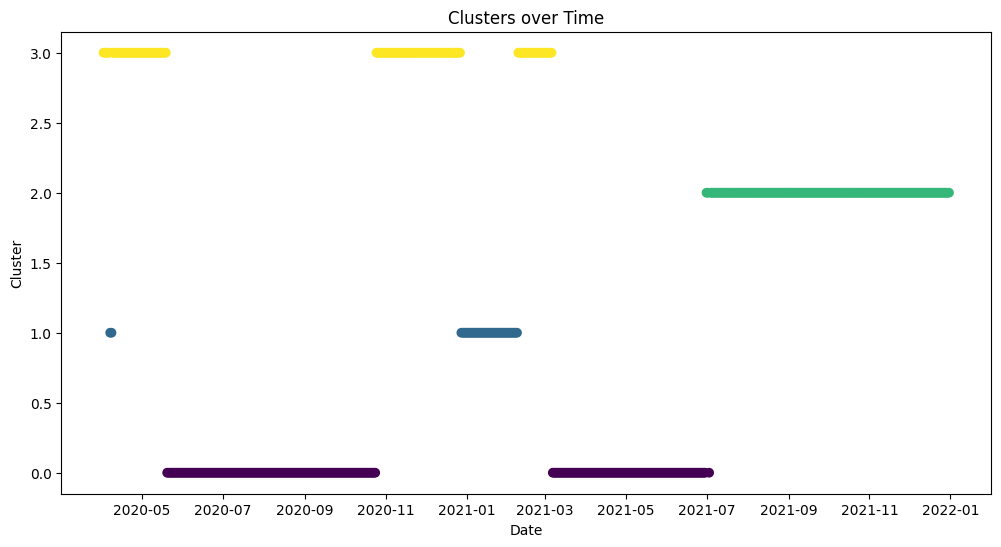

In [15]:
plt.figure(figsize=(12, 6))
plt.scatter(data['date'], data['Cluster'], c=data['Cluster'])
plt.title('Clusters over Time')
plt.xlabel('Date')
plt.ylabel('Cluster')
plt.show()


In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming 'data' is your DataFrame and 'MV Beds Occupied' is the target variable
# Convert the DataFrame to a PyTorch Tensor
data_tensor = torch.tensor(data, dtype=torch.float32)

# Define a function to create sequences
def create_sequences(input_data, target_column, sequence_length):
    sequences = []
    target_size = len(input_data) - sequence_length
    for i in range(target_size):
        sequence = input_data[i:i+sequence_length]
        target = input_data[i+sequence_length][target_column]
        sequences.append((sequence, target))
    return sequences

# Create sequences
sequence_length = 5  # This is a hyperparameter you can tune
target_column = data.columns.get_loc("MV Beds Occupied")
sequences = create_sequences(data_tensor, target_column, sequence_length)

# Split data into training and testing sets
train_size = int(0.8 * len(sequences))
train_sequences, test_sequences = sequences[:train_size], sequences[train_size:]

# Create DataLoaders
train_loader = DataLoader(train_sequences, batch_size=64, shuffle=True)
test_loader = DataLoader(test_sequences, batch_size=64, shuffle=False)


ValueError: could not determine the shape of object type 'DataFrame'